# Callisto Test Generation for Fashion MNIST

### Dependencies
* Python 3
* Keras
* Tensorflow==1.15.0
* Random
* Pickle
* Math
* Matplotlib
* OpenCV
* h5py


In [1]:
import tensorflow.keras as keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import math
import cv2
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix
from keras.models import Model
import _pickle as pickle
import copy
import random
import tensorflow as tf

Using TensorFlow backend.


### Please download the pre-trained Fashion MNIST model [here](https://drive.google.com/file/d/1G6F9oppcZveWdZa6wmXf18vfqC6tieUn/view?usp=sharing) and save it in the "models" folder under MNIST-Digit

### MD5 checksum = 555060f85df317e17df4a871f06ce71b

In [2]:
model1_file = "../models/Fashion-MNIST.h5py"

#### Please change 'MINI_DATASET_TEST' to False if you want to run the full MNIST dataset. Once it is set to true, the test generation framework will only run for a subset images in the interest of time. 

In [3]:
MINI_DATASET_TEST = True
MINI_DATASET_N = 1000

In [4]:
#Importing the training and testing data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train= x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

#Converting the labels to a categorical form
y_train=to_categorical(y_train, num_classes=10)
y_test=to_categorical(y_test, num_classes=10)

if MINI_DATASET_TEST:
    x_train = x_train[:MINI_DATASET_N]
    x_test = x_test[:MINI_DATASET_N]
    y_train = y_train[:MINI_DATASET_N]
    y_test = y_test[:MINI_DATASET_N]

In [5]:
#Model architechture
model1=Sequential()
model1.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1),padding="same",
                 kernel_initializer='random_uniform',
                bias_initializer='random_uniform',
                 activation='relu',input_shape=[28,28,1]))
model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid"))
model1.add(Conv2D(16,kernel_size=(3,3),strides=(1,1),padding="same",
                kernel_initializer='random_uniform',
                bias_initializer='random_uniform',
                activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid"))
model1.add(Flatten())
model1.add(Dense(100,activation="relu",kernel_initializer='random_uniform',
                bias_initializer='zeros'))
model1.add(Dense(10,activation="softmax",kernel_initializer='random_uniform',
                bias_initializer='zeros'))

W1207 23:30:41.971482 4472839488 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W1207 23:30:41.982048 4472839488 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [6]:
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
model1.load_weights(model1_file)

In [8]:
test_loss, test_acc = model1.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

W1207 23:30:42.177523 4472839488 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



1000/1000 [==============================] - 0s 106us/step
Test accuracy: 0.8949999809265137


In [9]:
layer_outputs = [layer.output for layer in model1.layers]

activation_model = Model(inputs=model1.input, outputs=layer_outputs)

### all_train_acts.pickle contains all the activations of the training data. This is necesscary for Callisto to calculate the shannon indices of the image input. Please download the file [here](https://drive.google.com/file/d/1xyoIpkv-L0SxMyxGnkSZzBd2JkiqTVJi/view?usp=sharing). The file should be saved in the "saved_pickles" folder Fashion-MNIST

### MD5 Sum = 8c82cbfa445c5626bbd207de514e1fab

In [10]:
with open('../saved_pickles/all_train_acts.pickle', 'rb') as handle: 
     all_acts = pickle.load(handle)
        
if MINI_DATASET_TEST:
    all_acts = all_acts[:MINI_DATASET_N]

In [11]:
def shannon(arrs):
    shannons = []
    for arr in arrs:
        sum = 0
        for i in arr:
            sum += (i*np.log(i))
        shannons.append(sum * -1.0)
    return shannons

In [12]:
all_shannons = shannon(all_acts)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in float_scalars
  


In [13]:
low_shannon_true = []
for i in range(len(all_shannons)):
    if all_shannons[i] < 0.001 and np.argmax(all_acts[i]) == np.argmax(y_train[i]) : 
        low_shannon_true.append(i)
        
print("low_shannon_true:", len(low_shannon_true))

low_shannon_true: 501


In [14]:
rows,cols = (28, 28)
M = np.float32([[1,0,2],[0,1,2]])

Original Image


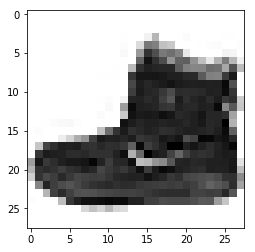

In [15]:
print("Original Image")
img = x_train[0]
label = y_train[0]
plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)
plt.show()

In [16]:
# Panning Transformation in openCV
rows,cols = (28, 28)
M = np.float32([[1,0,2],[0,1,2]])

Transformation: Panning


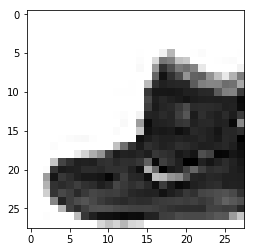

In [17]:
print("Transformation: Panning")
rows,cols = (28, 28)
M = np.float32([[1,0,2],[0,1,2]])
dst = cv2.warpAffine(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary)
plt.show()

In [18]:
print("Transformation: Panning")
cols,rows = 28, 28
count_made_false_low_shannon_true = 0
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = activation_model.predict(img)[6][0]
    
    dst = cv2.warpAffine(x_train[i],M,(28,28)).reshape(28,28,1)
    dst = (np.expand_dims(dst,0))
    dst_pred = activation_model.predict(dst)[6][0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1


print("Shannon Treshold : < 0.001")        
print("Number of inputs: ", len(low_shannon_true))        
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: Panning
Shannon Treshold : < 0.001
Number of inputs:  501
Error Rate:  0.19760479041916168


In [19]:
print("Transformation: Panning")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)

    print("Shannon Treshold : >", threshold)
    print("Number of inputs: ", len(high_shannon_true))

    count_made_false_high_shannon_true = 0
    
    if len(high_shannon_true) > 0:
        for i in high_shannon_true:
            img = x_train[i]
            label = y_train[i]
            img = (np.expand_dims(img,0))
            img_pred = activation_model.predict(img)[6][0]

            dst = cv2.warpAffine(x_train[i],M,(28,28)).reshape(28,28,1)
            dst = (np.expand_dims(dst,0))
            dst_pred = activation_model.predict(dst)[6][0]
            if (np.argmax(img_pred) != np.argmax(dst_pred)):
                count_made_false_high_shannon_true += 1

        print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
        
    else:
        print("No inputs with shannon index more than ", threshold)
        
    print("")

Transformation: Panning
Shannon Treshold : > 0.01
Number of inputs:  334
Error Rates : 0.4820359281437126

Shannon Treshold : > 0.025
Number of inputs:  283
Error Rates : 0.49469964664310956

Shannon Treshold : > 0.05
Number of inputs:  239
Error Rates : 0.49372384937238495

Shannon Treshold : > 0.1
Number of inputs:  181
Error Rates : 0.5193370165745856

Shannon Treshold : > 0.2
Number of inputs:  132
Error Rates : 0.553030303030303

Shannon Treshold : > 0.3
Number of inputs:  103
Error Rates : 0.5631067961165048

Shannon Treshold : > 0.4
Number of inputs:  78
Error Rates : 0.5512820512820513

Shannon Treshold : > 0.5
Number of inputs:  59
Error Rates : 0.5932203389830508

Shannon Treshold : > 0.6
Number of inputs:  51
Error Rates : 0.6078431372549019

Shannon Treshold : > 0.7
Number of inputs:  31
Error Rates : 0.7096774193548387

Shannon Treshold : > 0.8
Number of inputs:  16
Error Rates : 0.75

Shannon Treshold : > 0.9
Number of inputs:  14
Error Rates : 0.7142857142857143

Shannon

Transformation: 2D rotation


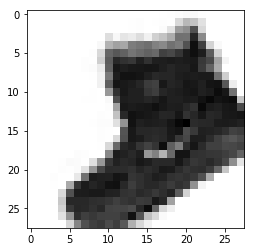

In [20]:
print("Transformation: 2D rotation")
rows,cols = (28, 28)
M = cv2.getRotationMatrix2D((cols/2,rows/2),30,1)
img = x_train[0]
dst = cv2.warpAffine(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary)
plt.show()

In [21]:
print("Transformation: Rotation")
cols,rows = 28, 28
count_made_false_low_shannon_true = 0
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = activation_model.predict(img)[6][0]
    
    dst = cv2.warpAffine(x_train[i],M,(28,28)).reshape(28,28,1)
    dst = (np.expand_dims(dst,0))
    dst_pred = activation_model.predict(dst)[6][0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1


print("Shannon Treshold : < 0.001")        
print("Number of inputs: ", len(low_shannon_true))        
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: Rotation
Shannon Treshold : < 0.001
Number of inputs:  501
Error Rate:  0.5988023952095808


In [22]:
print("Transformation: Rotation")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)

    print("Shannon Treshold : >", threshold)
    print("Number of inputs: ", len(high_shannon_true))

    count_made_false_high_shannon_true = 0
    
    if len(high_shannon_true) > 0:
        for i in high_shannon_true:
            img = x_train[i]
            label = y_train[i]
            img = (np.expand_dims(img,0))
            img_pred = activation_model.predict(img)[6][0]

            dst = cv2.warpAffine(x_train[i],M,(28,28)).reshape(28,28,1)
            dst = (np.expand_dims(dst,0))
            dst_pred = activation_model.predict(dst)[6][0]
            if (np.argmax(img_pred) != np.argmax(dst_pred)):
                count_made_false_high_shannon_true += 1

        print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
        
    else:
        print("No inputs with shannon index more than ", threshold)
        
    print("")

Transformation: Rotation
Shannon Treshold : > 0.01
Number of inputs:  334
Error Rates : 0.7664670658682635

Shannon Treshold : > 0.025
Number of inputs:  283
Error Rates : 0.7809187279151943

Shannon Treshold : > 0.05
Number of inputs:  239
Error Rates : 0.7866108786610879

Shannon Treshold : > 0.1
Number of inputs:  181
Error Rates : 0.7790055248618785

Shannon Treshold : > 0.2
Number of inputs:  132
Error Rates : 0.7575757575757576

Shannon Treshold : > 0.3
Number of inputs:  103
Error Rates : 0.7669902912621359

Shannon Treshold : > 0.4
Number of inputs:  78
Error Rates : 0.7948717948717948

Shannon Treshold : > 0.5
Number of inputs:  59
Error Rates : 0.8305084745762712

Shannon Treshold : > 0.6
Number of inputs:  51
Error Rates : 0.8431372549019608

Shannon Treshold : > 0.7
Number of inputs:  31
Error Rates : 0.8387096774193549

Shannon Treshold : > 0.8
Number of inputs:  16
Error Rates : 0.875

Shannon Treshold : > 0.9
Number of inputs:  14
Error Rates : 0.9285714285714286

Shanno

Transformation: Affine


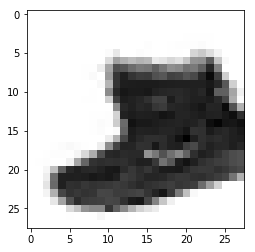

In [23]:
print("Transformation: Affine")
rows,cols = (28, 28)
pts1 = np.float32([[5,5],[24,5],[5,24]])
pts2 = np.float32([[1,10],[20,5],[10,25]])
M = cv2.getAffineTransform(pts1,pts2)
img = x_train[0]
dst = cv2.warpAffine(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary)
plt.show()

In [24]:
print("Transformation: Affine")
cols,rows = 28, 28
count_made_false_low_shannon_true = 0
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = activation_model.predict(img)[6][0]
    
    dst = cv2.warpAffine(x_train[i],M,(28,28)).reshape(28,28,1)
    dst = (np.expand_dims(dst,0))
    dst_pred = activation_model.predict(dst)[6][0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1


print("Shannon Treshold : < 0.001")        
print("Number of inputs: ", len(low_shannon_true))        
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: Affine
Shannon Treshold : < 0.001
Number of inputs:  501
Error Rate:  0.39520958083832336


In [25]:
print("Transformation: Affine")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)

    print("Shannon Treshold : >", threshold)
    print("Number of inputs: ", len(high_shannon_true))

    count_made_false_high_shannon_true = 0
    
    if len(high_shannon_true) > 0:
        for i in high_shannon_true:
            img = x_train[i]
            label = y_train[i]
            img = (np.expand_dims(img,0))
            img_pred = activation_model.predict(img)[6][0]

            dst = cv2.warpAffine(x_train[i],M,(28,28)).reshape(28,28,1)
            dst = (np.expand_dims(dst,0))
            dst_pred = activation_model.predict(dst)[6][0]
            if (np.argmax(img_pred) != np.argmax(dst_pred)):
                count_made_false_high_shannon_true += 1

        print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
        
    else:
        print("No inputs with shannon index more than ", threshold)
        
    print("")

Transformation: Affine
Shannon Treshold : > 0.01
Number of inputs:  334
Error Rates : 0.7544910179640718

Shannon Treshold : > 0.025
Number of inputs:  283
Error Rates : 0.7879858657243817

Shannon Treshold : > 0.05
Number of inputs:  239
Error Rates : 0.7949790794979079

Shannon Treshold : > 0.1
Number of inputs:  181
Error Rates : 0.8121546961325967

Shannon Treshold : > 0.2
Number of inputs:  132
Error Rates : 0.8106060606060606

Shannon Treshold : > 0.3
Number of inputs:  103
Error Rates : 0.8155339805825242

Shannon Treshold : > 0.4
Number of inputs:  78
Error Rates : 0.8717948717948718

Shannon Treshold : > 0.5
Number of inputs:  59
Error Rates : 0.8983050847457628

Shannon Treshold : > 0.6
Number of inputs:  51
Error Rates : 0.9019607843137255

Shannon Treshold : > 0.7
Number of inputs:  31
Error Rates : 0.8709677419354839

Shannon Treshold : > 0.8
Number of inputs:  16
Error Rates : 0.875

Shannon Treshold : > 0.9
Number of inputs:  14
Error Rates : 0.9285714285714286

Shannon 

Transformation: Perspective


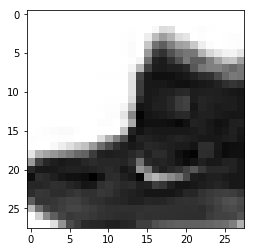

In [26]:
print("Transformation: Perspective")
rows,cols = (28, 28)
pts1 = np.float32([[1,1],[25,1],[1,25],[25,25]])
pts2 = np.float32([[0,0],[28,0],[0,28],[28,28]])
M = cv2.getPerspectiveTransform(pts1,pts2)
img = x_train[0]
dst = cv2.warpPerspective(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary)
plt.show()

In [27]:
print("Transformation: Perspective")
cols,rows = 28, 28
count_made_false_low_shannon_true = 0
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = activation_model.predict(img)[6][0]
    
    dst = cv2.warpPerspective(x_train[i],M,(28,28)).reshape(28,28,1)
    dst = (np.expand_dims(dst,0))
    dst_pred = activation_model.predict(dst)[6][0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1


print("Shannon Treshold : < 0.001")        
print("Number of inputs: ", len(low_shannon_true))        
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: Perspective
Shannon Treshold : < 0.001
Number of inputs:  501
Error Rate:  0.07584830339321358


In [28]:
print("Transformation: Perspective")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)

    print("Shannon Treshold : >", threshold)
    print("Number of inputs: ", len(high_shannon_true))

    count_made_false_high_shannon_true = 0
    
    if len(high_shannon_true) > 0:
        for i in high_shannon_true:
            img = x_train[i]
            label = y_train[i]
            img = (np.expand_dims(img,0))
            img_pred = activation_model.predict(img)[6][0]

            dst = cv2.warpPerspective(x_train[i],M,(28,28)).reshape(28,28,1)
            dst = (np.expand_dims(dst,0))
            dst_pred = activation_model.predict(dst)[6][0]
            if (np.argmax(img_pred) != np.argmax(dst_pred)):
                count_made_false_high_shannon_true += 1

        print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
        
    else:
        print("No inputs with shannon index more than ", threshold)
        
    print("")

Transformation: Perspective
Shannon Treshold : > 0.01
Number of inputs:  334
Error Rates : 0.4311377245508982

Shannon Treshold : > 0.025
Number of inputs:  283
Error Rates : 0.4628975265017668

Shannon Treshold : > 0.05
Number of inputs:  239
Error Rates : 0.4811715481171548

Shannon Treshold : > 0.1
Number of inputs:  181
Error Rates : 0.5138121546961326

Shannon Treshold : > 0.2
Number of inputs:  132
Error Rates : 0.5454545454545454

Shannon Treshold : > 0.3
Number of inputs:  103
Error Rates : 0.5436893203883495

Shannon Treshold : > 0.4
Number of inputs:  78
Error Rates : 0.5769230769230769

Shannon Treshold : > 0.5
Number of inputs:  59
Error Rates : 0.6440677966101694

Shannon Treshold : > 0.6
Number of inputs:  51
Error Rates : 0.6470588235294118

Shannon Treshold : > 0.7
Number of inputs:  31
Error Rates : 0.6774193548387096

Shannon Treshold : > 0.8
Number of inputs:  16
Error Rates : 0.6875

Shannon Treshold : > 0.9
Number of inputs:  14
Error Rates : 0.7142857142857143

Sh